<a href="https://colab.research.google.com/github/Sehlli/EFM-Tp/blob/main/EFM%20tp1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import numpy as np   # importing numpy, math , matplotlib librarie 
import math
from matplotlib import pyplot as plt

def shape(xi):   # function shape take list and  return   1D array 
	x,y = tuple(xi)
	N = [(1.0-x)*(1.0-y), (1.0+x)*(1.0-y), (1.0+x)*(1.0+y), (1.0-x)*(1.0+y)]
	return 0.25*np.array(N)
 
def gradshape(xi):    # function gradshape takes list and return 2D array 
	x,y = tuple(xi)
	dN = [[-(1.0-y),  (1.0-y), (1.0+y), -(1.0+y)],
		  [-(1.0-x), -(1.0+x), (1.0+x),  (1.0-x)]]
	return 0.25*np.array(dN)

In [30]:
print('create mesh')
# input
mesh_ex = 9
mesh_ey = 49
mesh_lx = 10.0
mesh_ly = 50.0
# derived
mesh_nx      = mesh_ex + 1
mesh_ny      = mesh_ey + 1
num_nodes    = mesh_nx * mesh_ny
num_elements = mesh_ex * mesh_ey
mesh_hx      = mesh_lx / mesh_ex
mesh_hy      = mesh_ly / mesh_ey
nodes = []
for y in np.linspace(0.0, mesh_ly, mesh_ny):
	for x in np.linspace(0.0, mesh_lx, mesh_nx):
		nodes.append([x,y])
nodes = np.array(nodes)
conn = []
for j in range(mesh_ey):
	for i in range(mesh_ex):
		n0 = i + j*mesh_nx
		conn.append([n0, n0 + 1, n0 + 1 + mesh_nx, n0 + mesh_nx])

create mesh


In [31]:
print ('material model - plane strain')
E = 100.0
v = 0.48
C = E/(1.0+v)/(1.0-2.0*v) * np.array([[1.0-v,     v,     0.0],
								      [    v, 1.0-v,     0.0],
								      [  0.0,   0.0,   0.5-v]])

material model - plane strain


In [32]:
print('create global stiffness matrix')
K = np.zeros((2*num_nodes, 2*num_nodes))
q4 = [[x/math.sqrt(3.0),y/math.sqrt(3.0)] for y in [-1.0,1.0] for x in [-1.0,1.0]]
B = np.zeros((3,8))
for c in conn:
	xIe = nodes[c,:]
	Ke = np.zeros((8,8))
	for q in q4:
		dN = gradshape(q)
		J  = np.dot(dN, xIe).T
		dN = np.dot(np.linalg.inv(J), dN)
		B[0,0::2] = dN[0,:]
		B[1,1::2] = dN[1,:]
		B[2,0::2] = dN[1,:]
		B[2,1::2] = dN[0,:]
		Ke += np.dot(np.dot(B.T,C),B) * np.linalg.det(J)
	for i,I in enumerate(c):
		for j,J in enumerate(c):
			K[2*I,2*J]     += Ke[2*i,2*j]
			K[2*I+1,2*J]   += Ke[2*i+1,2*j]
			K[2*I+1,2*J+1] += Ke[2*i+1,2*j+1]
			K[2*I,2*J+1]   += Ke[2*i,2*j+1]

create global stiffness matrix


In [33]:
print('assign nodal forces and boundary conditions')
f = np.zeros((2*num_nodes))
for i in range(num_nodes):
	if nodes[i,1] == 0.0:
		K[2*i,:]     = 0.0
		K[2*i+1,:]   = 0.0
		K[2*i,2*i]   = 1.0
		K[2*i+1,2*i+1] = 1.0
	if nodes[i,1] == mesh_ly:
		x = nodes[i,0]
		f[2*i+1] = 20.0
		if x == 0.0 or x == mesh_lx:
			f[2*i+1] *= 0.5

assign nodal forces and boundary conditions


In [34]:
print('solving linear system')
u = np.linalg.solve(K, f)
print('max u=', max(u))

solving linear system
max u= 6.745400245723836


plotting displacement


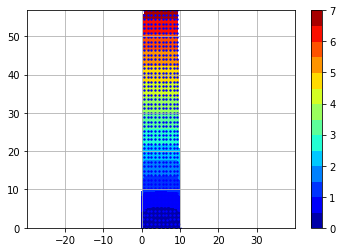

In [35]:
print('plotting displacement')
ux = np.reshape(u[0::2], (mesh_ny,mesh_nx))
uy = np.reshape(u[1::2], (mesh_ny,mesh_nx))
xvec = []
yvec = []
res  = []
for i in range(mesh_nx):
    for j in range(mesh_ny):
        xvec.append(i*mesh_hx + ux[j,i])
        yvec.append(j*mesh_hy + uy[j,i])
        res.append(uy[j,i])
t = plt.tricontourf(xvec, yvec, res, levels=14, cmap=plt.cm.jet)
plt.scatter(xvec, yvec, marker='o', c='b', s=2)
plt.grid()
plt.colorbar(t)
plt.axis('equal')
plt.show()